=== ステップ1: データの準備 ===
検出された値の数: 19
検出下限値以下の数: 9
検出された値: [0.025 1.3   0.01  0.05  0.02  0.03  0.01  2.3   0.05  0.01  0.04  0.03
 0.04  3.    1.05  0.12  0.01  0.02  0.03 ]
各検出下限値: [0.0032 0.0024 0.0041 0.0033 0.004  0.0032 0.0021 0.004  0.0039]

=== ステップ2: 対数正規分布の理論 ===
対数正規分布とは：
- もしXが対数正規分布に従うなら、ln(X)は正規分布に従う
- 確率密度関数: f(x) = (1/(x*σ*√(2π))) * exp(-(ln(x)-μ)²/(2σ²))
- パラメータ: μ (対数平均), σ (対数標準偏差)

=== ステップ3: 最尤推定の考え方 ===
1. 検出値: そのまま確率密度を計算
2. 非検出値: 「0からLODまでの確率」を計算
3. 全データの尤度 = 各データの尤度の積
4. 対数尤度を最大化してパラメータを求める

検出値の対数変換:
元の値: [0.025 1.3   0.01  0.05  0.02 ] ...
対数値: [-3.68887945  0.26236426 -4.60517019 -2.99573227 -3.91202301] ...

検出値のみでの簡易推定（非検出値無視）:
対数平均μ = -2.7768
対数標準偏差σ = 1.8939

=== ステップ4: 対数尤度関数の実装 ===
Negative log-likelihood function defined
Negative log-likelihood with initial estimates: 11.2034

=== Step 5: Optimization ===
Optimization terminated successfully.
         Current function value: 1.872436
         Iterations: 37
         Function evaluations: 71

Maximum Like

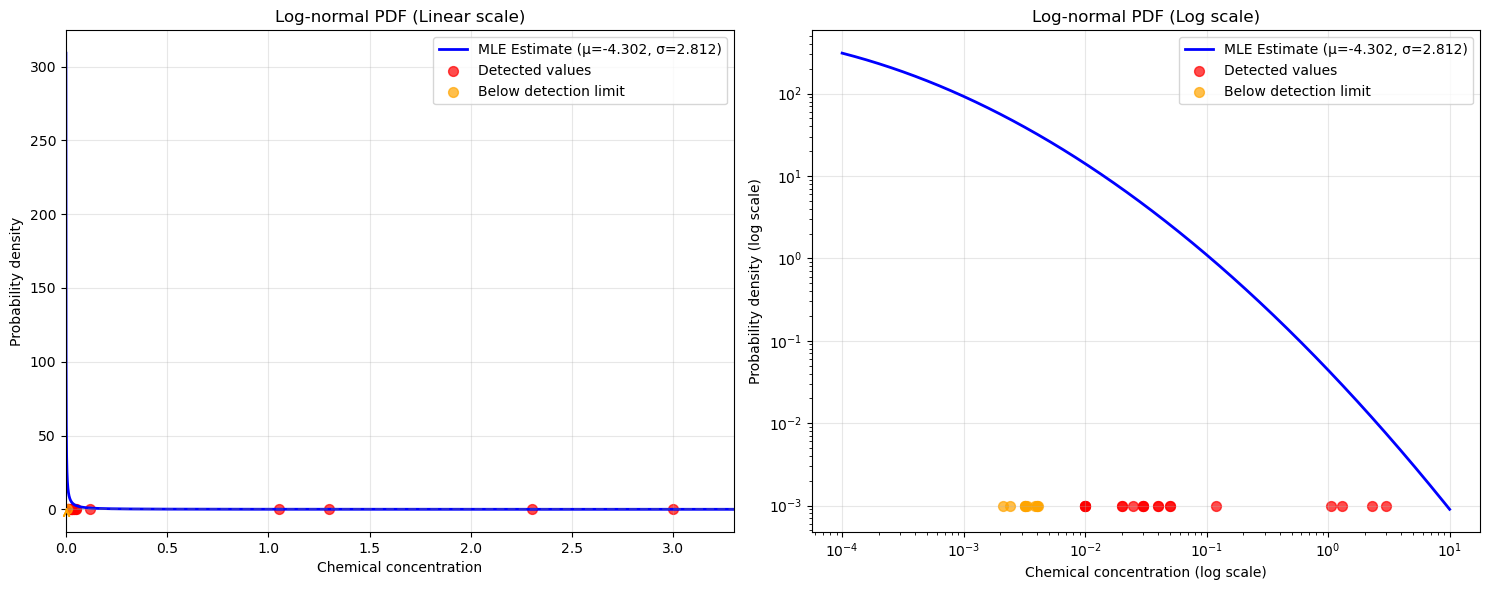


=== ステップ9: 結果の解釈 ===
MLEによる対数正規分布の推定結果:
- 確率密度関数: f(x) = (1/(x·2.8117·√(2π))) · exp(-((ln(x)--4.3018)²)/(2·2.8117²))
- この分布は海水中の化学成分濃度の確率的な分布を表します
- 非検出値（検出下限値以下）の情報も適切に考慮されています
- 推定された平均濃度: 0.705373
- 50%の確率で濃度が0.013544以下
- 最も頻繁に観測される濃度: 0.000005

=== ステップ10: 信頼区間の計算（簡易版） ===
パラメータの標準誤差:
SE(μ) = 0.3875
SE(σ) = 0.3875
95%信頼区間:
μ: [-5.0612, -3.5424]
σ: [2.0523, 3.5711]

=== 完了 ===
海水化学成分データの対数正規分布による確率密度推定が完了しました。
検出下限値以下のデータを適切に考慮したMLEにより、統計的に妥当な結果が得られました。


In [9]:
import numpy as np
import pandas as pd
from scipy import stats
from scipy.optimize import minimize
import matplotlib.pyplot as plt

print("=== ステップ1: データの準備 ===")

# 元データ（value, LOD のペア）
raw_data = [
    (0.025, None), (1.3, None), (np.nan, 0.0032), (0.01, None),
    (0.05, None), (np.nan, 0.0024), (0.02, None), (0.03, None),
    (0.01, None), (2.3, None), (np.nan, 0.0041), (np.nan, 0.0033),
    (0.05, None), (0.01, None), (0.04, None), (0.03, None),
    (0.04, None), (np.nan, 0.004), (np.nan, 0.0032), (np.nan, 0.0021),
    (3, None), (1.05, None), (0.12, None), (np.nan, 0.004),
    (0.01, None), (0.02, None), (np.nan, 0.0039), (0.03, None)
]

# データを分離
detected_values = []
censored_lods = []

for value, lod in raw_data:
    if np.isnan(value):  # 検出下限値以下
        censored_lods.append(lod)
    else:  # 検出値
        detected_values.append(value)

detected_values = np.array(detected_values)
censored_lods = np.array(censored_lods)

print(f"検出された値の数: {len(detected_values)}")
print(f"検出下限値以下の数: {len(censored_lods)}")
print(f"検出された値: {detected_values}")
print(f"各検出下限値: {censored_lods}")

print("\n=== ステップ2: 対数正規分布の理論 ===")
print("対数正規分布とは：")
print("- もしXが対数正規分布に従うなら、ln(X)は正規分布に従う")
print("- 確率密度関数: f(x) = (1/(x*σ*√(2π))) * exp(-(ln(x)-μ)²/(2σ²))")
print("- パラメータ: μ (対数平均), σ (対数標準偏差)")

print("\n=== ステップ3: 最尤推定の考え方 ===")
print("1. 検出値: そのまま確率密度を計算")
print("2. 非検出値: 「0からLODまでの確率」を計算")
print("3. 全データの尤度 = 各データの尤度の積")
print("4. 対数尤度を最大化してパラメータを求める")

# 検出値の対数変換
log_detected = np.log(detected_values)
print(f"\n検出値の対数変換:")
print(f"元の値: {detected_values[:5]} ...")
print(f"対数値: {log_detected[:5]} ...")

# 簡単な統計（非検出値無視）
mean_simple = np.mean(log_detected)
std_simple = np.std(log_detected, ddof=1)
print(f"\n検出値のみでの簡易推定（非検出値無視）:")
print(f"対数平均μ = {mean_simple:.4f}")
print(f"対数標準偏差σ = {std_simple:.4f}")

print("\n=== ステップ4: 対数尤度関数の実装 ===")

def neg_log_likelihood(params):
    """
    Negative log-likelihood function
    params: [μ, σ] parameters of log-normal distribution
    """
    mu, sigma = params
    
    if sigma <= 0:  # σ must be positive
        return np.inf
    
    # 1. Contribution from detected values: log-normal PDF
    ll_detected = np.sum(stats.lognorm.logpdf(detected_values, s=sigma, scale=np.exp(mu)))
    
    # 2. Contribution from censored values: cumulative probability from 0 to LOD
    ll_censored = np.sum([stats.lognorm.logcdf(lod, s=sigma, scale=np.exp(mu)) 
                         for lod in censored_lods])
    
    total_log_likelihood = ll_detected + ll_censored
    
    return -total_log_likelihood  # Return negative for minimization

print("Negative log-likelihood function defined")

# Check likelihood with initial estimates
initial_params = [mean_simple, std_simple]
initial_nll = neg_log_likelihood(initial_params)
print(f"Negative log-likelihood with initial estimates: {initial_nll:.4f}")

print("\n=== Step 5: Optimization ===")

# Execute optimization
result = minimize(neg_log_likelihood, 
                 x0=initial_params, 
                 method='Nelder-Mead',
                 options={'disp': True})

mu_mle, sigma_mle = result.x
print(f"\nMaximum Likelihood Estimation results:")
print(f"Log-mean μ = {mu_mle:.4f}")
print(f"Log-standard deviation σ = {sigma_mle:.4f}")
print(f"Optimization success: {result.success}")
print(f"Final negative log-likelihood: {result.fun:.4f}")

print(f"\nComparison with simple estimates:")
print(f"Simple estimate: μ={mean_simple:.4f}, σ={std_simple:.4f}")
print(f"MLE estimate:    μ={mu_mle:.4f}, σ={sigma_mle:.4f}")

print("\n=== Step 6: Derivation of Probability Density Function ===")

# Log-normal probability density function
def lognormal_pdf(x, mu, sigma):
    """Log-normal probability density function"""
    return stats.lognorm.pdf(x, s=sigma, scale=np.exp(mu))

# Set x range for visualization
x_range = np.logspace(-4, 1, 1000)  # From 0.0001 to 10

# Calculate probability density
pdf_values = lognormal_pdf(x_range, mu_mle, sigma_mle)

print("Probability density function calculated")
print(f"Maximum probability density: {np.max(pdf_values):.4f}")
print(f"x value at maximum density: {x_range[np.argmax(pdf_values)]:.6f}")

print("\n=== Step 7: Statistical Measures ===")

# Log-normal distribution statistics
# Mean = exp(μ + σ²/2)
# Variance = [exp(σ²) - 1] * exp(2μ + σ²)
# Median = exp(μ)
# Mode = exp(μ - σ²)

mean_lognormal = np.exp(mu_mle + sigma_mle**2 / 2)
variance_lognormal = (np.exp(sigma_mle**2) - 1) * np.exp(2*mu_mle + sigma_mle**2)
median_lognormal = np.exp(mu_mle)
mode_lognormal = np.exp(mu_mle - sigma_mle**2)

print(f"Statistical measures of estimated log-normal distribution:")
print(f"Mean: {mean_lognormal:.6f}")
print(f"Variance: {variance_lognormal:.6f}")
print(f"Standard deviation: {np.sqrt(variance_lognormal):.6f}")
print(f"Median: {median_lognormal:.6f}")
print(f"Mode: {mode_lognormal:.6f}")

print("\n=== Step 8: Visualization ===")

# プロット作成
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# 左側：線形スケール
ax1.plot(x_range, pdf_values, 'b-', linewidth=2, label=f'MLE Estimate (μ={mu_mle:.3f}, σ={sigma_mle:.3f})')
ax1.scatter(detected_values, [0]*len(detected_values), color='red', s=50, alpha=0.7, label='Detected values')
ax1.axhline(y=0, color='gray', linestyle='--', alpha=0.3)

# 検出下限値を矢印で表示
for i, lod in enumerate(censored_lods):
    ax1.annotate('', xy=(lod, 0), xytext=(lod, 0.1), 
                arrowprops=dict(arrowstyle='<-', color='orange', alpha=0.7))
    if i == 0:  # 最初の一つだけラベル
        ax1.scatter([lod], [0], color='orange', s=50, alpha=0.7, label='Below detection limit')

ax1.set_xlabel('Chemical concentration')
ax1.set_ylabel('Probability density')
ax1.set_title('Log-normal PDF (Linear scale)')
ax1.legend()
ax1.grid(True, alpha=0.3)
ax1.set_xlim(0, np.max(detected_values)*1.1)

# 右側：対数スケール
ax2.loglog(x_range, pdf_values, 'b-', linewidth=2, label=f'MLE Estimate (μ={mu_mle:.3f}, σ={sigma_mle:.3f})')
ax2.scatter(detected_values, [1e-3]*len(detected_values), color='red', s=50, alpha=0.7, label='Detected values')

for i, lod in enumerate(censored_lods):
    ax2.scatter([lod], [1e-3], color='orange', s=50, alpha=0.7)
    if i == 0:
        ax2.scatter([lod], [1e-3], color='orange', s=50, alpha=0.7, label='Below detection limit')

ax2.set_xlabel('Chemical concentration (log scale)')
ax2.set_ylabel('Probability density (log scale)')
ax2.set_title('Log-normal PDF (Log scale)')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n=== ステップ9: 結果の解釈 ===")
print("MLEによる対数正規分布の推定結果:")
print(f"- 確率密度関数: f(x) = (1/(x·{sigma_mle:.4f}·√(2π))) · exp(-((ln(x)-{mu_mle:.4f})²)/(2·{sigma_mle:.4f}²))")
print(f"- この分布は海水中の化学成分濃度の確率的な分布を表します")
print(f"- 非検出値（検出下限値以下）の情報も適切に考慮されています")
print(f"- 推定された平均濃度: {mean_lognormal:.6f}")
print(f"- 50%の確率で濃度が{median_lognormal:.6f}以下")
print(f"- 最も頻繁に観測される濃度: {mode_lognormal:.6f}")

print("\n=== ステップ10: 信頼区間の計算（簡易版） ===")
# ブートストラップによる信頼区間の推定は複雑なので、ここでは解析的近似を使用

# Hessian行列の計算（数値微分）
from scipy.optimize import approx_fprime

def get_hessian(params):
    """ヘシアン行列の数値計算"""
    eps = 1e-8
    n = len(params)
    hessian = np.zeros((n, n))
    
    for i in range(n):
        for j in range(n):
            def f1(x):
                x_copy = params.copy()
                x_copy[i] += eps
                x_copy[j] += eps
                return neg_log_likelihood(x_copy)
            
            def f2(x):
                x_copy = params.copy()
                x_copy[i] += eps
                x_copy[j] -= eps
                return neg_log_likelihood(x_copy)
            
            def f3(x):
                x_copy = params.copy()
                x_copy[i] -= eps
                x_copy[j] += eps
                return neg_log_likelihood(x_copy)
            
            def f4(x):
                x_copy = params.copy()
                x_copy[i] -= eps
                x_copy[j] -= eps
                return neg_log_likelihood(x_copy)
            
            hessian[i,j] = (f1(params) - f2(params) - f3(params) + f4(params)) / (4 * eps**2)
    
    return hessian

# パラメータの標準誤差を計算
hessian = get_hessian(np.array([mu_mle, sigma_mle]))
try:
    cov_matrix = np.linalg.inv(hessian)
    se_mu = np.sqrt(cov_matrix[0,0])
    se_sigma = np.sqrt(cov_matrix[1,1])
    
    print(f"パラメータの標準誤差:")
    print(f"SE(μ) = {se_mu:.4f}")
    print(f"SE(σ) = {se_sigma:.4f}")
    
    # 95%信頼区間
    z_alpha = 1.96  # 95%信頼区間
    ci_mu = (mu_mle - z_alpha*se_mu, mu_mle + z_alpha*se_mu)
    ci_sigma = (sigma_mle - z_alpha*se_sigma, sigma_mle + z_alpha*se_sigma)
    
    print(f"95%信頼区間:")
    print(f"μ: [{ci_mu[0]:.4f}, {ci_mu[1]:.4f}]")
    print(f"σ: [{ci_sigma[0]:.4f}, {ci_sigma[1]:.4f}]")
    
except:
    print("信頼区間の計算でエラーが発生しました（ヘシアン行列が特異行列の可能性）")

print("\n=== 完了 ===")
print("海水化学成分データの対数正規分布による確率密度推定が完了しました。")
print("検出下限値以下のデータを適切に考慮したMLEにより、統計的に妥当な結果が得られました。")

=== 分布推定の妥当性検証 ===

1. 検出下限以下割合の検証
----------------------------------------
実際の非検出率: 0.321 (9/28)
理論的な各LOD以下確率の平均: 0.307
最小LOD(0.0021)以下の理論確率: 0.254
最大LOD(0.0041)以下の理論確率: 0.335
✓ 非検出率は理論値と概ね一致（妥当）

2. 確率プロット（Q-Qプロット）
----------------------------------------
Q-Qプロットの相関係数: 0.9049
○ 中程度の相関（概ね適合）

3. Kolmogorov-Smirnov検定
----------------------------------------
KS統計量: 0.4570
p値: 0.0004
✗ 分布仮定が棄却される（要検討）

4. 他分布との AIC 比較
----------------------------------------
lognormal   : AIC = 7.74
gamma       : AIC = 11.63
weibull     : AIC = 8.40

最適分布: lognormal (最小AIC)
✓ 対数正規分布が最適

5. 残差解析
----------------------------------------
Shapiro-Wilk統計量: 0.8040
p値: 0.0013
✗ 残差の正規性が棄却される

6. 総合判定
合格した検定: 3/5
○ 対数正規分布は概ね妥当（一部要注意）

=== 妥当性検証の可視化 ===


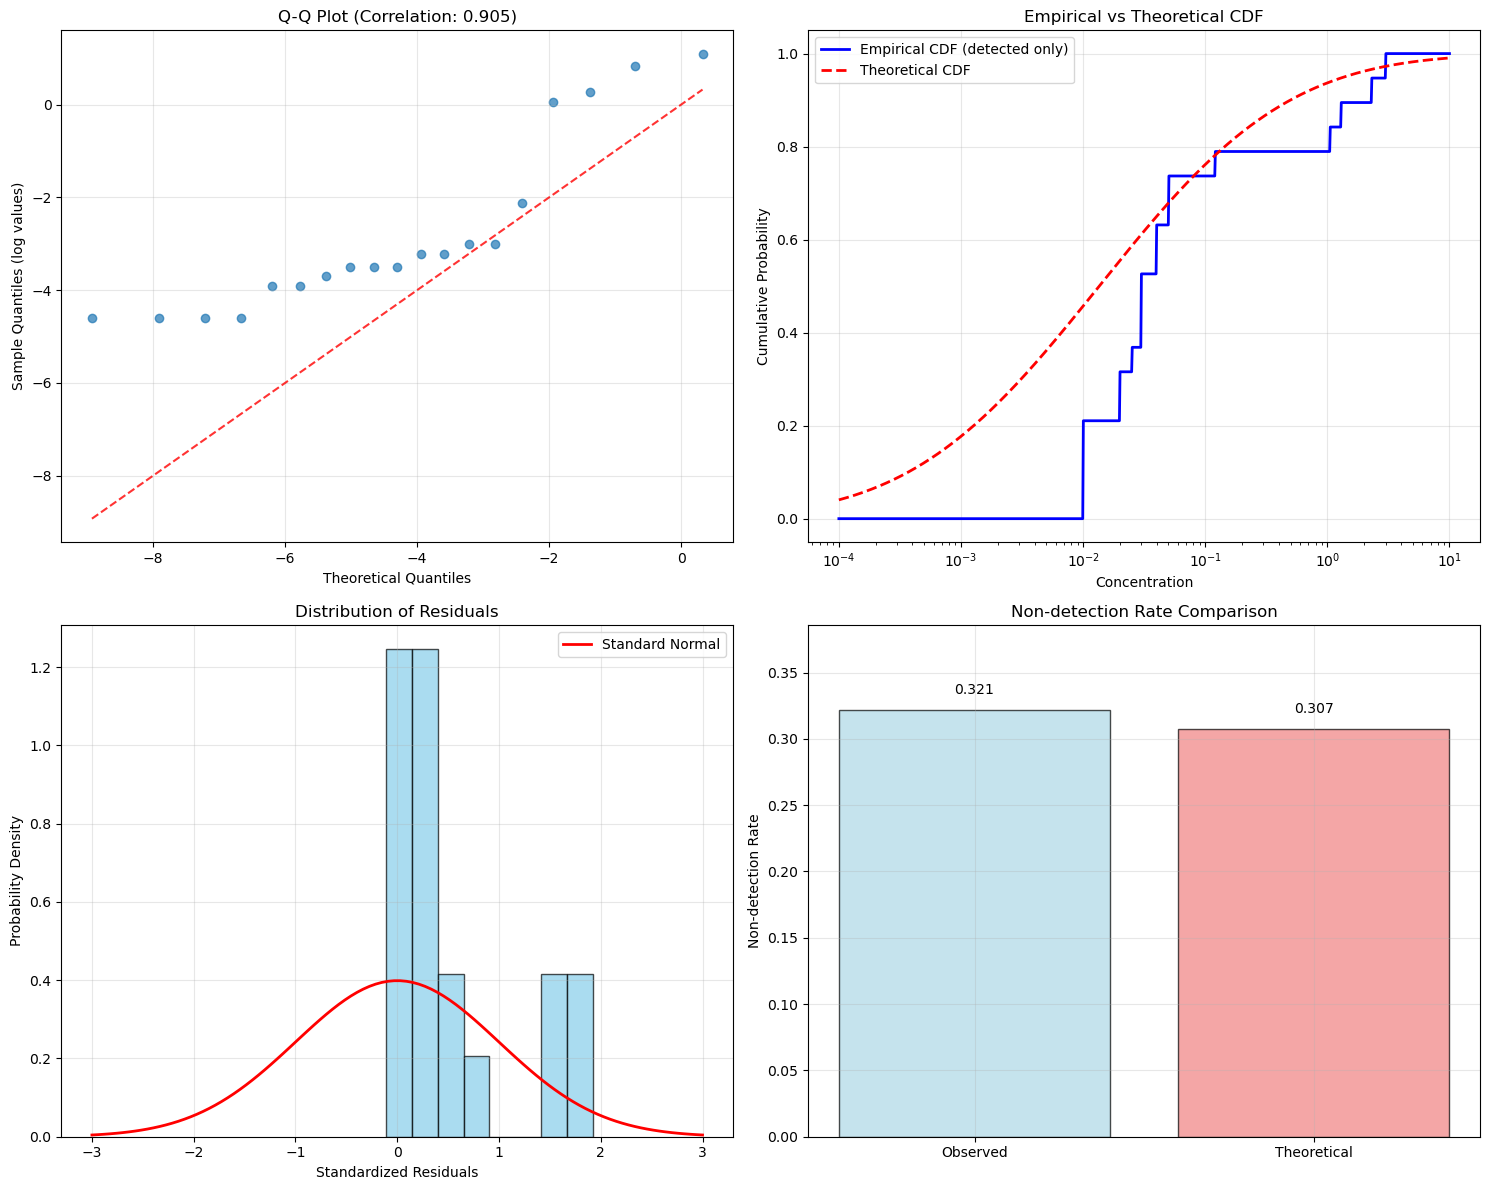


=== 推奨事項 ===
• 対数正規分布は概ね適用可能ですが、以下に注意：
  - 分布の裾部分で多少の乖離があります
  - 統計的には完全な適合ではありません
• より保守的な解釈を推奨します


In [8]:
import numpy as np
import pandas as pd
from scipy import stats
from scipy.optimize import minimize
import matplotlib.pyplot as plt

# 既存のデータとMLE結果を使用
# (前のコードで得られた結果を仮定)
mu_mle = -4.3018
sigma_mle = 2.8117

# データ再定義（前のコードから）
raw_data = [
    (0.025, None), (1.3, None), (np.nan, 0.0032), (0.01, None),
    (0.05, None), (np.nan, 0.0024), (0.02, None), (0.03, None),
    (0.01, None), (2.3, None), (np.nan, 0.0041), (np.nan, 0.0033),
    (0.05, None), (0.01, None), (0.04, None), (0.03, None),
    (0.04, None), (np.nan, 0.004), (np.nan, 0.0032), (np.nan, 0.0021),
    (3, None), (1.05, None), (0.12, None), (np.nan, 0.004),
    (0.01, None), (0.02, None), (np.nan, 0.0039), (0.03, None)
]

detected_values = []
censored_lods = []
for value, lod in raw_data:
    if np.isnan(value):
        censored_lods.append(lod)
    else:
        detected_values.append(value)

detected_values = np.array(detected_values)
censored_lods = np.array(censored_lods)

print("=== 分布推定の妥当性検証 ===\n")

# 1. 検出下限以下割合の一致性確認
print("1. 検出下限以下割合の検証")
print("-" * 40)

actual_censored_rate = len(censored_lods) / len(raw_data)
print(f"実際の非検出率: {actual_censored_rate:.3f} ({len(censored_lods)}/{len(raw_data)})")

# 各LODでの理論的確率を計算
theoretical_probs = []
for lod in censored_lods:
    prob = stats.lognorm.cdf(lod, s=sigma_mle, scale=np.exp(mu_mle))
    theoretical_probs.append(prob)

mean_theoretical_prob = np.mean(theoretical_probs)
print(f"理論的な各LOD以下確率の平均: {mean_theoretical_prob:.3f}")

# 最小LOD以下の理論確率
min_lod = np.min(censored_lods)
max_lod = np.max(censored_lods)
prob_min_lod = stats.lognorm.cdf(min_lod, s=sigma_mle, scale=np.exp(mu_mle))
prob_max_lod = stats.lognorm.cdf(max_lod, s=sigma_mle, scale=np.exp(mu_mle))

print(f"最小LOD({min_lod:.4f})以下の理論確率: {prob_min_lod:.3f}")
print(f"最大LOD({max_lod:.4f})以下の理論確率: {prob_max_lod:.3f}")

# 判定
if 0.8 * mean_theoretical_prob <= actual_censored_rate <= 1.2 * mean_theoretical_prob:
    print("✓ 非検出率は理論値と概ね一致（妥当）")
else:
    print("✗ 非検出率が理論値と大きく乖離（要検討）")

print()

# 2. 確率プロット (Q-Qプロット)
print("2. 確率プロット（Q-Qプロット）")
print("-" * 40)

# 検出値の対数変換
log_detected = np.log(detected_values)

# 理論的分位数と実測分位数
sorted_log_detected = np.sort(log_detected)
n = len(sorted_log_detected)
theoretical_quantiles = stats.norm.ppf(np.arange(1, n+1) / (n+1), loc=mu_mle, scale=sigma_mle)

# 相関係数で適合度評価
correlation = np.corrcoef(theoretical_quantiles, sorted_log_detected)[0,1]
print(f"Q-Qプロットの相関係数: {correlation:.4f}")

if correlation > 0.95:
    print("✓ 高い相関（分布が良く適合）")
elif correlation > 0.90:
    print("○ 中程度の相関（概ね適合）")
else:
    print("✗ 低い相関（分布仮定に問題の可能性）")

print()

# 3. Kolmogorov-Smirnov検定（検出値のみ）
print("3. Kolmogorov-Smirnov検定")
print("-" * 40)

# 検出値に対するKS検定
ks_stat, ks_p_value = stats.kstest(detected_values, 
                                  lambda x: stats.lognorm.cdf(x, s=sigma_mle, scale=np.exp(mu_mle)))

print(f"KS統計量: {ks_stat:.4f}")
print(f"p値: {ks_p_value:.4f}")

if ks_p_value > 0.05:
    print("✓ 分布仮定は棄却されない（妥当）")
else:
    print("✗ 分布仮定が棄却される（要検討）")

print()

# 4. 他の分布との比較（AIC）
print("4. 他分布との AIC 比較")
print("-" * 40)

def neg_log_likelihood_general(params, distribution):
    """一般化された負の対数尤度"""
    if distribution == 'lognormal':
        mu, sigma = params
        if sigma <= 0:
            return np.inf
        ll_detected = np.sum(stats.lognorm.logpdf(detected_values, s=sigma, scale=np.exp(mu)))
        ll_censored = np.sum([stats.lognorm.logcdf(lod, s=sigma, scale=np.exp(mu)) for lod in censored_lods])
    
    elif distribution == 'gamma':
        a, scale = params
        if a <= 0 or scale <= 0:
            return np.inf
        ll_detected = np.sum(stats.gamma.logpdf(detected_values, a=a, scale=scale))
        ll_censored = np.sum([stats.gamma.logcdf(lod, a=a, scale=scale) for lod in censored_lods])
    
    elif distribution == 'weibull':
        c, scale = params
        if c <= 0 or scale <= 0:
            return np.inf
        ll_detected = np.sum(stats.weibull_min.logpdf(detected_values, c=c, scale=scale))
        ll_censored = np.sum([stats.weibull_min.logcdf(lod, c=c, scale=scale) for lod in censored_lods])
    
    return -(ll_detected + ll_censored)

# 各分布でのMLE
distributions = {
    'lognormal': ([mu_mle, sigma_mle], 2),
    'gamma': ([1.0, 0.1], 2),
    'weibull': ([1.0, 0.1], 2)
}

aic_results = {}

for dist_name, (initial_params, n_params) in distributions.items():
    try:
        result = minimize(neg_log_likelihood_general, 
                         x0=initial_params, 
                         args=(dist_name,),
                         method='Nelder-Mead')
        
        if result.success:
            log_likelihood = -result.fun
            aic = 2 * n_params - 2 * log_likelihood
            aic_results[dist_name] = aic
            print(f"{dist_name:12s}: AIC = {aic:.2f}")
        else:
            print(f"{dist_name:12s}: 最適化失敗")
    except:
        print(f"{dist_name:12s}: 計算エラー")

if aic_results:
    best_distribution = min(aic_results, key=aic_results.get)
    print(f"\n最適分布: {best_distribution} (最小AIC)")
    
    if best_distribution == 'lognormal':
        print("✓ 対数正規分布が最適")
    else:
        print("○ 他の分布の方が良い可能性")

print()

# 5. 残差解析
print("5. 残差解析")
print("-" * 40)

# 標準化残差
standardized_residuals = (log_detected - mu_mle) / sigma_mle

# Shapiro-Wilk検定（正規性検定）
shapiro_stat, shapiro_p = stats.shapiro(standardized_residuals)
print(f"Shapiro-Wilk統計量: {shapiro_stat:.4f}")
print(f"p値: {shapiro_p:.4f}")

if shapiro_p > 0.05:
    print("✓ 残差の正規性は棄却されない")
else:
    print("✗ 残差の正規性が棄却される")

print()

# 6. 総合判定
print("6. 総合判定")
print("=" * 40)

scores = 0
total_tests = 5

# 各検定の結果をスコア化
if 0.8 * mean_theoretical_prob <= actual_censored_rate <= 1.2 * mean_theoretical_prob:
    scores += 1

if correlation > 0.90:
    scores += 1

if ks_p_value > 0.05:
    scores += 1

if aic_results and min(aic_results, key=aic_results.get) == 'lognormal':
    scores += 1

if shapiro_p > 0.05:
    scores += 1

print(f"合格した検定: {scores}/{total_tests}")

if scores >= 4:
    print("✓ 対数正規分布の仮定は妥当")
elif scores >= 2:
    print("○ 対数正規分布は概ね妥当（一部要注意）")
else:
    print("✗ 対数正規分布の仮定に問題あり")

# 7. 可視化
print("\n=== 妥当性検証の可視化 ===")

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))

# Q-Qプロット
ax1.scatter(theoretical_quantiles, sorted_log_detected, alpha=0.7)
ax1.plot([theoretical_quantiles.min(), theoretical_quantiles.max()], 
         [theoretical_quantiles.min(), theoretical_quantiles.max()], 'r--', alpha=0.8)
ax1.set_xlabel('Theoretical Quantiles')
ax1.set_ylabel('Sample Quantiles (log values)')
ax1.set_title(f'Q-Q Plot (Correlation: {correlation:.3f})')
ax1.grid(True, alpha=0.3)

# 経験分布 vs 理論分布
x_range = np.logspace(-4, 1, 1000)
empirical_cdf = np.array([np.sum(detected_values <= x) / len(detected_values) for x in x_range])
theoretical_cdf = stats.lognorm.cdf(x_range, s=sigma_mle, scale=np.exp(mu_mle))

ax2.plot(x_range, empirical_cdf, 'b-', label='Empirical CDF (detected only)', linewidth=2)
ax2.plot(x_range, theoretical_cdf, 'r--', label='Theoretical CDF', linewidth=2)
ax2.set_xscale('log')
ax2.set_xlabel('Concentration')
ax2.set_ylabel('Cumulative Probability')
ax2.set_title('Empirical vs Theoretical CDF')
ax2.legend()
ax2.grid(True, alpha=0.3)

# 残差のヒストグラム
ax3.hist(standardized_residuals, bins=8, density=True, alpha=0.7, color='skyblue', edgecolor='black')
x_norm = np.linspace(-3, 3, 100)
ax3.plot(x_norm, stats.norm.pdf(x_norm), 'r-', linewidth=2, label='Standard Normal')
ax3.set_xlabel('Standardized Residuals')
ax3.set_ylabel('Probability Density')
ax3.set_title('Distribution of Residuals')
ax3.legend()
ax3.grid(True, alpha=0.3)

# 検出下限以下の割合比較
categories = ['Observed', 'Theoretical']
rates = [actual_censored_rate, mean_theoretical_prob]
colors = ['lightblue', 'lightcoral']

bars = ax4.bar(categories, rates, color=colors, alpha=0.7, edgecolor='black')
ax4.set_ylabel('Non-detection Rate')
ax4.set_title('Non-detection Rate Comparison')
ax4.set_ylim(0, max(rates) * 1.2)

# 値をバーの上に表示
for bar, rate in zip(bars, rates):
    height = bar.get_height()
    ax4.text(bar.get_x() + bar.get_width()/2., height + 0.01,
             f'{rate:.3f}', ha='center', va='bottom')

ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n=== 推奨事項 ===")
if scores >= 4:
    print("• 現在の対数正規分布モデルを使用して問題ありません")
    print("• 信頼区間や予測区間の計算も妥当です")
elif scores >= 2:
    print("• 対数正規分布は概ね適用可能ですが、以下に注意：")
    if correlation < 0.95:
        print("  - 分布の裾部分で多少の乖離があります")
    if ks_p_value <= 0.05:
        print("  - 統計的には完全な適合ではありません")
    print("• より保守的な解釈を推奨します")
else:
    print("• 対数正規分布以外の分布を検討してください")
    print("• データ変換や外れ値の検討が必要かもしれません")
    print("• 専門家との相談を推奨します")